# Application
This notebook covers the application of developed algorithm in a wider settings, including the prediction of a wider selection of ChEMBL drugs and drug candidates.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedGroupKFold

from nonconformist.icp import IcpClassifier
from nonconformist.nc import NcFactory, InverseProbabilityErrFunc
from nonconformist.acp import RandomSubSampler, AggregatedCp

from utils import get_chembl_drugs_with_descriptors, COLOUR_CNSDB, COLOUR_CHEMBL, COLOUR_POSITIVE, COLOUR_NEGATIVE


def cp_ensembl_predict_significance(cp_ensemble, X):
    return pd.DataFrame(np.mean([mod.predict(X) for mod in cp_ensemble], axis=0))


def cp_ensemble_predict_efficient_single_classification(cp_ensemble, X, significance):
    """
    Given an ensemble of conformal predictors, predict one-class efficient classification i.e. only return a class label if a single class is predicted under a particular significance level. Return no prediction if no or multiple classes are predicted.     
    """
    p_vals = cp_ensembl_predict_significance(cp_ensemble, X)
    return p_vals.apply(axis=1, func=lambda x: 0 if (x[0] >= significance > x[1]) else 1 if (x[1] >= significance > x[0]) else None)

df_chembl_drugs = get_chembl_drugs_with_descriptors()
df_chembl_drugs = df_chembl_drugs.loc[:,~df_chembl_drugs.columns.duplicated()].copy()
print(f"Read {len(df_chembl_drugs)} ChEMBL drugs.")
df_cns_db = pd.read_csv("cns_db_split_descriptors.tsv", sep="\t")
df_cns_db['BBB_numeric'] = df_cns_db['BBB+/BBB-'].map({'BBB+': 1, 'BBB-': 0})
print(f"Read {len(df_cns_db)} B3DB KC records.")

In [ ]:
from matplotlib_venn import venn2
venn2((
    set(df_cns_db.smiles),
    set(df_chembl_drugs.canonical_smiles)), ["CNS-DB", "ChEMBL"], set_colors=[COLOUR_CNSDB, COLOUR_CHEMBL])


In [ ]:
_model = RandomForestClassifier(n_estimators=100, max_depth=18, random_state=42)

icp_classifier_condition = (lambda instance: instance[1]) # Mondrian condition in conformal prediction
acp_aggregation_function = (lambda x: np.median(x, axis=2)) # Function to aggregate p-values in ACP

def train_acp_cv(data_X, class_y, data_groups, acp_model_count, normaliser_model=None, acp_option=None, cv_n_splits=5):
    if acp_option is None:
        acp_option = RandomSubSampler(calibration_portion=0.3)
 
    kf = StratifiedGroupKFold(n_splits=cv_n_splits, random_state=42, shuffle=True)
    acps_cv = []
    
    for i, (train_index, test_index) in enumerate(kf.split(data_X, class_y, data_groups)):
        print(f"Fold {i}, #training: {len(train_index)}, #test {len(test_index)}")
        X_train, X_test = data_X[train_index], data_X[test_index]
        y_train, y_test = class_y[train_index], class_y[test_index]
        
        mod = clone(_model)
        nc = NcFactory.create_nc(mod, err_func=InverseProbabilityErrFunc(), normalizer_model=normaliser_model)
        icp = IcpClassifier(nc, condition=icp_classifier_condition)
        acp = AggregatedCp(n_models=acp_model_count, predictor=icp, sampler=acp_option,
                           aggregation_func=acp_aggregation_function)
        acp.fit(X_train, y_train)
        
        acps_cv.append(acp)
    
    return acps_cv

np.random.seed(42)
features = SIMPLE_FILTERED_FEATURES = [
    'desc2D_TPSA',
    'desc2D_NumHDonors',
    'desc2D_MolWt',
    'chemaxon_logp',
    'chemaxon_logd',
    'chemaxon_pka_b',
    'desc2D_NumHAcceptors',
    'desc2D_HeavyAtomCount',
    'desc2D_MinPartialCharge',
    'desc2D_MaxPartialCharge',
    'desc2D_qed',
    'desc2D_MinEStateIndex',
    'desc2D_HallKierAlpha',
    'desc2D_Kappa3',
    'desc2D_Ipc',
    'desc2D_FractionCSP3',
    'desc2D_MinAbsEStateIndex',
    'desc2D_MaxAbsEStateIndex',
    'desc2D_NumRotatableBonds',
    'desc2D_NumAliphaticHeterocycles',
    'desc2D_NumSaturatedCarbocycles',
    'desc2D_BalabanJ',
    'desc2D_NumSpiroAtoms',
    'desc2D_NumAtomStereoCenters',
    'desc2D_NumBridgeheadAtoms',
    'desc2D_NumUnspecifiedAtomStereoCenters',
    'desc2D_NumRadicalElectrons',
    'desc2D_SPS',
] + [fn for fn in list(df_cns_db) if fn.startswith("maccs")]
acp_ensemble = train_acp_cv(df_cns_db[features].to_numpy(), df_cns_db["BBB_numeric"].to_numpy(), df_cns_db["murcko_scaffold_grouped"].to_numpy(), acp_model_count=25)

In [ ]:
df_cns_db.split.value_counts()

In [ ]:
pred_by_sig = []
for i in range(1, 101):
    significance = i / 100
    chembl_predicted = cp_ensemble_predict_efficient_single_classification(acp_ensemble, df_chembl_drugs.head(100000)[features].to_numpy(), significance=significance)
    pred_by_sig.append( {"significance": significance} | {k if pd.notna(k) else "undefined": v for k, v in dict(chembl_predicted.value_counts(dropna=False)).items()})
_df = pd.DataFrame(pred_by_sig)
_total = _df.iloc[-1]["undefined"]
_df["cumsum_positive"] = _df[1]
_df["cumsum_positive_negative"] = _df[0] + _df[1]
_df["total"] = _total

plt.figure(figsize=(10, 6))
# plt.fill_between(_df['significance'], 0, _df['total'], color=COLOUR_GRAY, label='No single label', alpha=0.7)
plt.fill_between(_df['significance'], 0, _df['cumsum_positive_negative'], color=COLOUR_NEGATIVE, label='BBB-', alpha=0.7)
plt.fill_between(_df['significance'], 0, _df['cumsum_positive'], color=COLOUR_POSITIVE, label='BBB+', alpha=0.7)

plt.xticks(ticks=np.arange(0, 1.1, 0.1))
plt.xlabel('Significance')
plt.ylabel('Predicted permeability class')
plt.ylim(0, _total)
plt.xlim(0, 1)
plt.legend()
plt.grid(False)
plt.savefig('figures/figure_12.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [ ]:
for i in range(1, 10):
    _sig = i/10
    df_chembl_drugs[f"pred_sig_{_sig}"] = cp_ensemble_predict_efficient_single_classification(acp_ensemble, df_chembl_drugs[features].to_numpy(), significance=_sig).apply(lambda x: x if pd.notna(x) else "Undefined")

In [ ]:
_df = df_chembl_drugs[df_chembl_drugs.indication_class_normalised.apply(len) > 0]
print(f"{len(_df)} drugs with normalised class")
_df = _df.explode(["indication_class_normalised"]) 
print(f"{len(_df)} molecule-indication class links")
print(f"A total of {_df.indication_class_normalised.nunique()} indication classes")
_icc = _df.indication_class_normalised.value_counts()
_min_drugs = 20
_ind = _icc[_icc >= _min_drugs]  # This is sorted in descending order
_df = _df[_df.indication_class_normalised.apply(lambda x: x in _ind)]
print(f"{len(_ind)} indication classes with more than {_min_drugs} molecules, with a total of {len(_df)} molecule-indication class links")
_df["indication_class_total"] = _df["indication_class_normalised"].apply(lambda x: _ind[x])

In [ ]:
_df.groupby("indication_class_normalised")["pred_sig_0.4"].apply(list).apply(lambda x: len([y for y in x if y == 1])/ len(x)).to_frame().sort_values("pred_sig_0.4", ascending=False).index

Processing significance 0.2
Processing significance 0.4
Processing significance 0.6


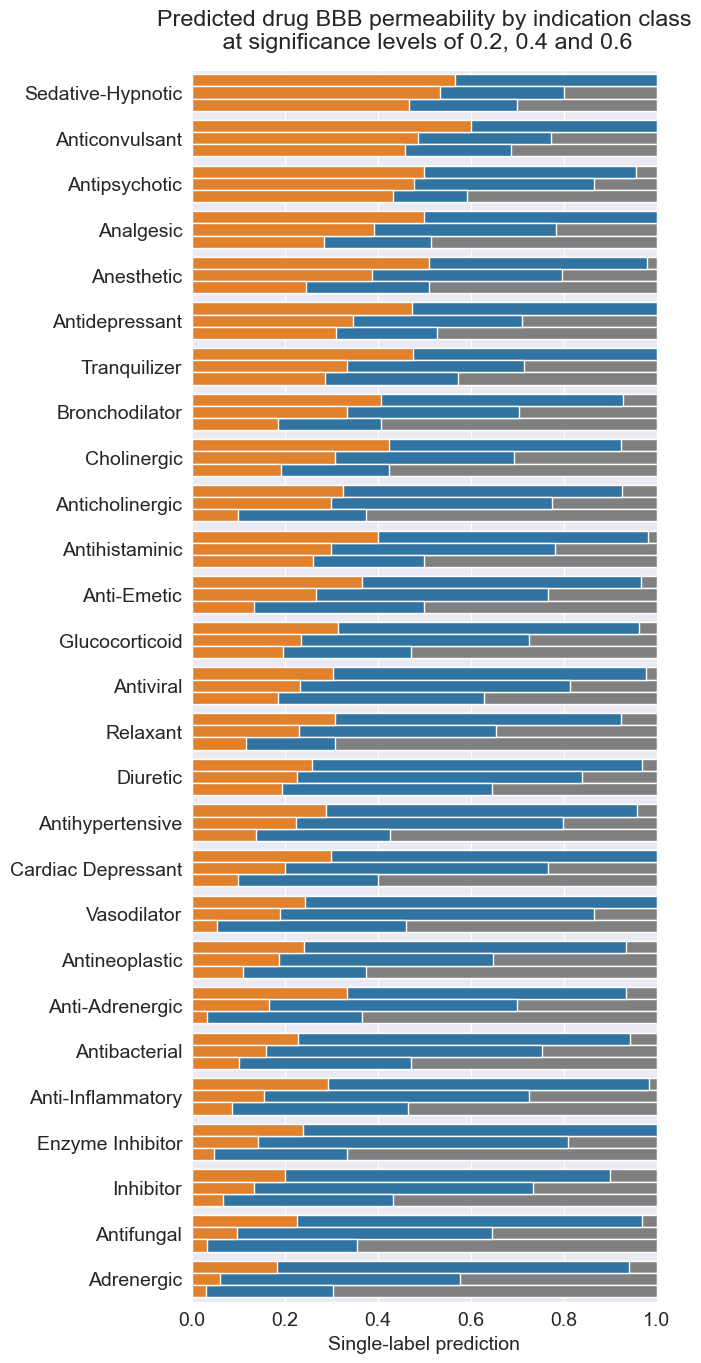

In [91]:
# To be run twice to fix the ordering.
from utils import COLOUR_GRAY
_z = []

ordered_indication_classes = list(
    _df.groupby("indication_class_normalised")["pred_sig_0.4"].apply(list).apply(lambda x: len([y for y in x if y == 1])/ len(x)).to_frame().sort_values("pred_sig_0.4", ascending=False).index)
for ii in [2, 4, 6]:
    _sig = ii/10
    print("Processing significance", _sig)
    #for _i in list(_df[_df.pred_sig==0.4].sort_values(by="positive_norm", ascending=False).indication_class_normalised): #_ind.index:
    for _i in ordered_indication_classes:
        if _i in {"Vitamin", "Diagnostic Aid", "Pharmaceutic Aid", "Antiparkinsonian"}:
            continue
        _dfi = _df[_df.indication_class_normalised == _i]
        _iv = {
            "significance": _sig,
            "indication_class_normalised": _i,
            "count": _ind[_i],
            "positive_norm":  sum(_dfi[f"pred_sig_{_sig}"] == 1) / len(_dfi),
            "negative_norm":  sum(_dfi[f"pred_sig_{_sig}"] == 0) / len(_dfi),
            "total": 1,
        }
        _iv["cumsum_positive"] = _iv["positive_norm"]
        _iv["cumsum_positive_negative"] = _iv["positive_norm"] + _iv["negative_norm"]
        _z.append(_iv)
__df = pd.DataFrame(_z)



plt.figure(figsize=(6, 16))
plt.rcParams.update({'font.size': 14})

sns.barplot(__df, x='total', y="indication_class_normalised",  hue='significance',  alpha=1 , palette=[COLOUR_GRAY] * 3)
sns.barplot(__df, x='cumsum_positive_negative', y="indication_class_normalised",  hue='significance', alpha=1, palette=[COLOUR_NEGATIVE] * 3)
sns.barplot(__df, x='cumsum_positive', y="indication_class_normalised",  hue='significance', palette=[COLOUR_POSITIVE] * 3)
plt.legend().remove()
plt.xlabel('Single-label prediction')
plt.ylabel('')
plt.xlim(0, 1)

_ = plt.title("Predicted drug BBB permeability by indication class\n at significance levels of 0.2, 0.4 and 0.6", pad=15)
plt.savefig('figures/figure_13.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [ ]:
_df.groupby("indication_class_normalised")["pred_sig_0.4"].apply(list).apply(lambda x: len([y for y in x if y == 1])/ len(x)).to_frame().sort_values("pred_sig_0.4", ascending=False).index

In [ ]:
## Predict the permeability of all INDs that reached at least Phase 1 clinical trials.
from utils import get_chembl_small_molecules_with_descriptors

df_chembl_investigational = get_chembl_small_molecules_with_descriptors(min_max_phase=-1)
print(f"Read {len(df_chembl_investigational)} ChEMBL molecules.")

for i in range(1, 8):
    _sig = i/10
    df_chembl_investigational[f"pred_sig_{_sig}"] = cp_ensemble_predict_efficient_single_classification(acp_ensemble, df_chembl_investigational[features].to_numpy(), significance=_sig).apply(lambda x: x if pd.notna(x) else "Undefined")

_to = "chembl_34_investigational_cp_bbb_permeability.csv"
df_chembl_investigational[["chembl_id"] + [c for c in list(df_chembl_investigational) if c.startswith("pred_sig")]].to_csv(_to, index=False)
print(f"Saved {len(df_chembl_investigational)} ChEMBL investigational compound predictions to {_to}")